In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41459")
client

<Client: 'tcp://127.0.0.1:41459' processes=8 threads=8, memory=384.02 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import sys
import gsw
import oceanmodes
import dask.array as dsar
from scipy.io import loadmat
from scipy.interpolate import interp1d
from xgcm.grid import Grid
from numpy.fft import fftfreq, fftshift
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.colors as clr
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/gpfs/research/coaps/tu22/HYCOM50/'

In [4]:
idm = 6709 
jdm = 7373
kdm = 32
layers = np.arange(kdm)

ychunk = 100
xchunk = 80
lchunk = 4

rho0 = 1000. 
g = 9.806 

In [5]:
yS, yN = (30,55)
xW, xE = (-80,-30)
ddeg = 1/50
nC = 100

In [6]:
nF = 30
if nF == 30:
    run = 'ATLb'
else:
    run = 'ATLc'

ds = xr.open_zarr(op.join(ddir,'%4s0.02/topo/Metrics.zarr' % run)
                 ).sel(YC=slice(yS-ddeg,yN+2*ddeg),YG=slice(yS-ddeg,yN+2*ddeg),
                       XC=slice(xW-ddeg,xE+2*ddeg),XG=slice(xW-ddeg,xE+2*ddeg)
                      ).isel(YG=slice(None,-1),XC=slice(1,None)
                            )
ds.coords['layer'] = np.arange(.5,32.5,1)
ds.coords['layerp1'] = np.arange(33)
ds.coords['layerl'] = ds.layerp1[:-1].data
ds.coords['layerp0'] = ds.layerp1[1:-1].data

ds

<xarray.Dataset>
Dimensions:  (YC: 1942, XG: 2473, YG: 1942, XC: 2473, layer: 32, layerp1: 33,
              layerl: 32, layerp0: 31)
Coordinates:
  * XC       (XC) float64 -80.0 -79.98 -79.96 -79.94 ... -30.01 -29.99 -29.96
  * XG       (XG) float64 -80.01 -79.99 -79.97 -79.95 ... -30.02 -30.0 -29.97
  * YC       (YC) float64 29.99 30.01 30.02 30.04 ... 55.01 55.02 55.03 55.04
  * YG       (YG) float64 29.98 30.0 30.01 30.03 ... 55.0 55.01 55.02 55.03
  * layer    (layer) float64 0.5 1.5 2.5 3.5 4.5 ... 27.5 28.5 29.5 30.5 31.5
  * layerp1  (layerp1) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * layerl   (layerl) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * layerp0  (layerp0) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31
Data variables:
    DXC      (YC, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DXF      (YG, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DXG      (YG, XC) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DYC      (YG, XC) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DYF      (YG, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DYG      (YC, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>

In [7]:
coords={
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "layer",  "outer": "layerp1", 
              "left"  : "layerl", "inner": "layerp0"
             }
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )

grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   layer --> left
  * outer    layerp1 --> center
  * left     layerl --> center
  * inner    layerp0 --> center

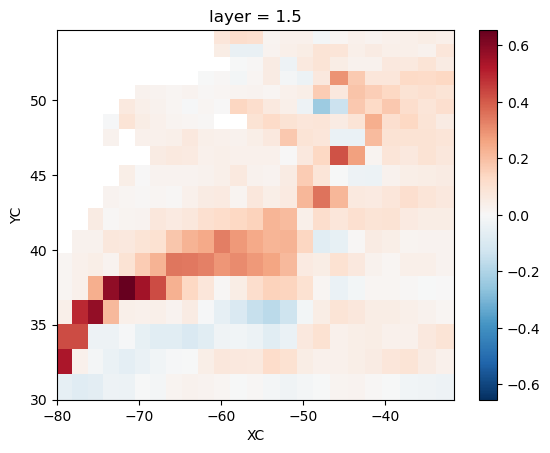

In [8]:
dsZ = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/dZp1.zarr' 
                           % (run,nF))
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),
                        XC=slice(xW-ddeg,xE+2*ddeg)
                       ).isel(XC=slice(1,None))
yA = (grid.interp(ds.DYG,'X',boundary='extend')
      * dsZ.dZp1).coarsen({'YC':nC,'XC':nC}, boundary='trim'
                         ).sum(skipna=True)
dsU = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/U.zarr' 
                           % (run,nF))
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),
                        XG=slice(xW-ddeg,xE+2*ddeg)
                       )
u = ((grid.interp(dsU.U*ds.DYG,'X',boundary='extend')
      * dsZ.dZp1
     ).coarsen({'YC':nC,'XC':nC}, boundary='trim'
              ).sum(skipna=True)
     / yA).compute()
xA = (grid.interp(ds.DXG,'Y',boundary='extend')
      * dsZ.dZp1).coarsen({'YC':nC,'XC':nC}, boundary='trim'
                         ).sum(skipna=True)
dsV = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/V.zarr' 
                           % (run,nF))
                  ).sel(YG=slice(yS-ddeg,yN+2*ddeg),
                        XC=slice(xW-ddeg,xE+2*ddeg)
                       ).isel(YG=slice(None,-1),XC=slice(1,None)
                             )
v = ((grid.interp(dsV.V*ds.DXG,'Y',boundary='extend')
      * dsZ.dZp1).coarsen({'XC':nC,'YC':nC}, boundary='trim'
                         ).sum(skipna=True)
     / xA).compute()
u.isel(layer=1).plot()

In [9]:
dsCoar = ds.coarsen({'YC':nC,'XC':nC,
                     'YG':nC,'XG':nC},
                     boundary='trim'
                    ).mean(skipna=True).compute()
gridC = Grid(dsCoar, periodic=[],
             coords=coords
            )

dsC = xr.open_zarr(op.join(ddir,'%4s0.02/topo/Coords.zarr' % run)
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),YG=slice(yS-ddeg,yN+2*ddeg),
                        XC=slice(xW-ddeg,xE+2*ddeg),XG=slice(xW-ddeg,xE+2*ddeg)
                       ).isel(YG=slice(None,-1),XC=slice(1,None)
                             ).coarsen({'YC':nC,'XC':nC,
                                        'YG':nC,'XG':nC},
                                       boundary='trim'
                                      ).mean(skipna=True).compute()

dsC

<xarray.Dataset>
Dimensions:  (YC: 19, XC: 24, XG: 24, YG: 19)
Coordinates:
  * XC       (XC) float64 -79.07 -77.19 -75.31 -73.41 ... -37.06 -34.88 -32.68
  * XG       (XG) float64 -79.08 -77.2 -75.32 -73.42 ... -37.07 -34.89 -32.69
  * YC       (YC) float64 30.84 32.54 34.21 35.85 ... 51.49 52.42 53.34 54.23
  * YG       (YG) float64 30.83 32.53 34.2 35.84 ... 51.48 52.42 53.33 54.23
Data variables:
    tlat     (YC, XC) float64 30.84 30.84 30.84 30.84 ... 55.93 56.02 56.11
    tlon     (YC, XC) float64 -76.75 -74.75 -72.75 ... -35.37 -33.31 -31.25
    ulon     (YC, XG) float64 -76.76 -74.76 -72.76 ... -35.38 -33.32 -31.26
    vlat     (YG, XC) float64 30.83 30.83 30.83 30.83 ... 55.82 55.92 56.02 56.1

In [10]:
dsN = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/N2.zarr' 
                           % (run,nF))
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),
                        XC=slice(xW-ddeg,xE+2*ddeg)
                       )
Vol = (grid.interp(ds.DYG,'X',boundary='extend')
       * grid.interp(ds.DXG,'Y',boundary='extend')
       * grid.interp(dsZ.dZp1.chunk({'layer':-1}),'Z',boundary='extend',to='inner')
      ).coarsen({'YC':nC,'XC':nC}, boundary='trim'
               ).sum(skipna=True)
n2 = ((dsN.N2 
       * grid.interp(ds.DYG,'X',boundary='extend')
       * grid.interp(ds.DXG,'Y',boundary='extend') 
       * grid.interp(dsZ.dZp1.chunk({'layer':-1}),'Z',boundary='extend',to='inner')
      ).coarsen({'YC':nC,'XC':nC}, boundary='trim'
               ).sum(skipna=True)
      / Vol).compute()
n2

<xarray.DataArray (layerp0: 31, YC: 19, XC: 24)>
array([[[3.98506456e-05, 3.44464042e-05, 3.33685012e-05, ...,
         3.15166990e-05, 3.23527798e-05, 3.23314187e-05],
        [5.58493958e-05, 3.56351344e-05, 2.74730724e-05, ...,
         2.92234044e-05, 3.28334479e-05, 3.15228335e-05],
        [5.95561732e-05, 5.34317502e-05, 3.08592082e-05, ...,
         2.54793553e-05, 2.79293396e-05, 2.99618979e-05],
        ...,
        [           nan,            nan,            nan, ...,
         3.24051382e-06, 2.18743282e-06, 1.78373122e-06],
        [           nan,            nan,            nan, ...,
         2.60454272e-06, 1.87929420e-06, 1.62482456e-06],
        [           nan,            nan,            nan, ...,
         1.94678199e-06, 1.71027738e-06, 1.23805090e-06]],

       [[1.22386751e-05, 1.43914792e-05, 1.71948203e-05, ...,
         5.54393114e-06, 4.99726366e-06, 4.44900165e-06],
        [1.17262456e-05, 6.88631915e-06, 8.64579002e-06, ...,
         7.99194342e-06, 8.13410855e-06, 6.82141409e-06],
        [1.46479519e-05, 6.22719622e-06, 6.83870876e-06, ...,
         1.06242807e-05, 1.42288464e-05, 1.36929927e-05],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * XC       (XC) float64 -79.07 -77.19 -75.31 -73.41 ... -37.06 -34.88 -32.68
  * YC       (YC) float64 30.84 32.54 34.21 35.85 ... 51.49 52.42 53.34 54.23
  * layerp0  (layerp0) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31

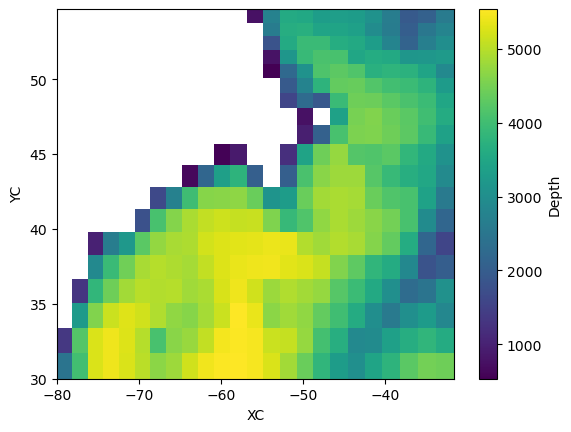

In [11]:
dsl = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/Rd.zarr' 
                           % (run,nF))
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),
                        XC=slice(xW-ddeg,xE+2*ddeg)
                       ).coarsen({'YC':nC,'XC':nC},
                                 boundary='trim'
                                ).mean(skipna=True).compute()
dsl.Depth.where(dsl.Depth>500).plot()

In [93]:
nz = 50
j = 37
i = -60

z = np.linspace(dsN.Z.sel(YC=j, XC=i, method='nearest')[0], 
                dsN.Z.sel(YC=j, XC=i, method='nearest')[-1], 
                num=nz,
                endpoint=False)
fU = interp1d(dsN.Z.sel(YC=j, XC=i, method='nearest'),
              grid.interp(dsU.U,'X',boundary='extend').sel(YC=j, XC=i, method='nearest'),
              fill_value='extrapolate'
             )
fV = interp1d(dsN.Z.sel(YC=j, XC=i, method='nearest'), 
              grid.interp(dsV.V,'Y',boundary='extend').sel(YC=j, XC=i, method='nearest'),
              fill_value='extrapolate'
             )
zN = .5*(z[1:] + z[:-1])
fN = interp1d(grid.interp(dsN.Z,'Z',boundary='extend'
                         ).isel(layerl=slice(1,None)
                               ).sel(YC=j, XC=i, method='nearest'), 
              dsN.N2.sel(YC=j, XC=i, method='nearest'),
              fill_value='extrapolate'
             )
 

In [94]:
nk = 64
k = 2*np.pi*np.linspace(-10e3**-1,10e3**-1,nk)   

zp, omega, psi = oceanmodes.instability_analysis_from_N2_profile(
                            zN, fN(zN),
                            f.sel(YC=j, XC=i, method='nearest').data, 
                            beta.sel(YC=j, XC=i, method='nearest').data,
                            k, k[nk//2:],
                            z, fU(z), fV(z),
                            np.array([0.,0.]), np.array([0.,0.]),
                            depth=dsl.Depth.sel(YC=j, XC=i, method='nearest').data    
            )

/gpfs/research/coaps/tu22/oceanmodes/oceanmodes/baroclinic.py:385: UserWarning: N2 is shorter than horizontal velocities by more than one element
  warnings.warn('N2 is shorter than horizontal velocities by more than one element')


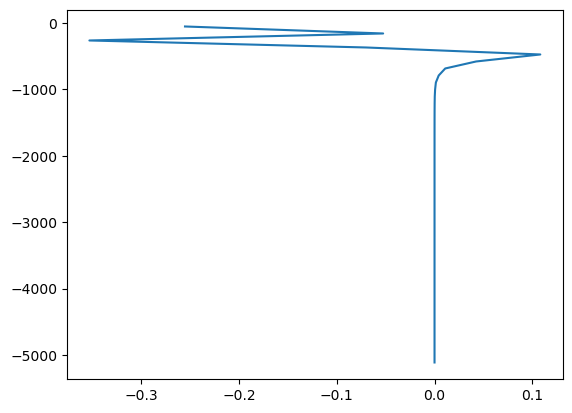

In [104]:
nmode = 0
indices = np.where(omega.imag[nmode] == omega.imag[nmode].max())
plt.plot(psi[:,nmode,indices[0][0],indices[1][0]],-zN)

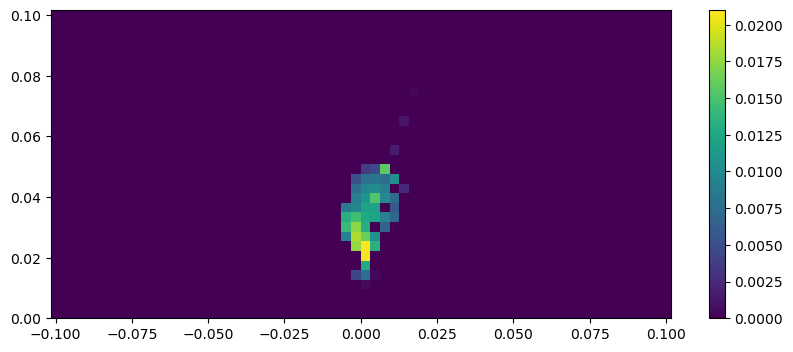

In [105]:
fig, ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(k/(2*np.pi)*1e3, k[nk//2:]/(2*np.pi)*1e3,
                   omega.imag[nmode]*86400, vmin=0)
fig.colorbar(im)

In [12]:
z = np.linspace(dsN.Z.where(dsN.Z>0.).isel(layer=0).max(skipna=True),
                dsN.Z.where(dsN.Z>0.).max(skipna=True), 
                num=75
               )
zN = .5*(z[1:] + z[:-1])
z = xr.DataArray(z, dims='Z', coords={'Z':z})
zN = xr.DataArray(zN, dims='Zn', coords={'Zn':zN})
rA = (grid.interp(ds.DYG,'X',boundary='extend')
      * grid.interp(ds.DXG,'Y',boundary='extend')
     )
oriZ = ((dsN.Z * rA).coarsen({'YC':nC,'XC':nC}, boundary='trim').sum(skipna=True)
        / rA.coarsen({'YC':nC,'XC':nC}, boundary='trim').sum(skipna=True)
       )
# U = grid.interp(dsU.U,'X',boundary='extend')
U = grid.transform(xr.DataArray(u.chunk({'layer':-1}).data,
                                dims=['layer','YC','XC'],
                                coords={'layer':ds.layer,'YC':dsCoar.YC,
                                        'XC':dsCoar.XC}), 
                   'Z', z, 
                   target_data=xr.DataArray(oriZ.chunk({'layer':-1}).data,
                                dims=['layer','YC','XC'],
                                coords={'layer':ds.layer,'YC':dsCoar.YC,
                                        'XC':dsCoar.XC})
                  ).transpose('Z','YC','XC').load()
# V = grid.interp(dsV.V,'Y',boundary='extend')
V = grid.transform(xr.DataArray(v.chunk({'layer':-1}).data,
                                dims=['layer','YC','XC'],
                                coords={'layer':ds.layer,'YC':dsCoar.YC,
                                        'XC':dsCoar.XC}), 
                   'Z', z, 
                   target_data=xr.DataArray(oriZ.chunk({'layer':-1}).data,
                                dims=['layer','YC','XC'],
                                coords={'layer':ds.layer,'YC':dsCoar.YC,
                                        'XC':dsCoar.XC})
                  ).transpose('Z','YC','XC').load()
U

/gpfs/research/coaps/tu22/conda-envs/py10/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/gpfs/research/coaps/tu22/conda-envs/py10/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


<xarray.DataArray 'xarray-<this-array>-d5ad05dcf0b9d63a1d06ebe9324416c5' (
                                                                          Z: 75,
                                                                          YC: 19,
                                                                          XC: 24)>
array([[[-0.05955264, -0.07805875, -0.06950173, ..., -0.03170083,
         -0.03783676, -0.0428363 ],
        [ 0.53469019,  0.03276685, -0.01118276, ...,  0.08923518,
          0.05161937,  0.02627415],
        [ 0.42661785,  0.43072999, -0.0261851 , ...,  0.03678264,
          0.0717863 ,  0.08964737],
        ...,
        [        nan,         nan,         nan, ...,         nan,
          0.11662272,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.10764402],
        [        nan,         nan,         nan, ...,         nan,
          0.07260349,  0.06506986]],

       [[-0.01347473, -0.05137213, -0.08704025, ..., -0.01710006,
         -0.02220825, -0.01705907],
        [ 0.56043819,  0.04449475, -0.03520313, ...,  0.08370503,
          0.05347208,  0.03537939],
        [ 0.18850735,  0.46057442, -0.01835878, ...,  0.03489975,
          0.08234398,  0.10322404],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * YC       (YC) float64 30.84 32.54 34.21 35.85 ... 51.49 52.42 53.34 54.23
  * XC       (XC) float64 -79.07 -77.19 -75.31 -73.41 ... -37.06 -34.88 -32.68
  * Z        (Z) float64 1.5 83.28 165.1 246.9 ... 5.89e+03 5.972e+03 6.053e+03

In [13]:
oriZ = ((grid.interp(dsN.Z.chunk({'layer':-1}), 'Z',
                     boundary='extend',to='inner')
         * rA).coarsen({'YC':nC,'XC':nC}, boundary='trim').sum(skipna=True)
        / rA.coarsen({'YC':nC,'XC':nC}, boundary='trim').sum(skipna=True)
       )
N2 = grid.transform(xr.DataArray(n2.chunk({'layerp0':-1}).data,
                                 dims=['layerp0','YC','XC'],
                                 coords={'layerp0':ds.layerp0,'YC':dsCoar.YC,
                                         'XC':dsCoar.XC}), 
                    'Z', zN, 
                    target_data=xr.DataArray(oriZ.chunk({'layerp0':-1}).data,
                                             dims=['layerp0','YC','XC'],
                                             coords={'layerp0':ds.layerp0,'YC':dsCoar.YC,
                                                     'XC':dsCoar.XC})
                   ).transpose('Zn','YC','XC').load()
N2

/gpfs/research/coaps/tu22/conda-envs/py10/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


<xarray.DataArray 'xarray-<this-array>-145f9f23dae615df54a630777d85dafc' (
                                                                          Zn: 74,
                                                                          YC: 19,
                                                                          XC: 24)>
array([[[1.91754214e-04, 1.82734972e-04, 1.42271878e-04, ...,
         1.19084185e-04, 1.20558936e-04, 1.26417633e-04],
        [1.91677719e-04, 1.71085888e-04, 1.89079984e-04, ...,
         1.28021300e-04, 1.25648028e-04, 1.22398042e-04],
        [3.06778039e-04, 1.91683643e-04, 1.75813463e-04, ...,
         1.36390875e-04, 1.37674306e-04, 1.35333986e-04],
        ...,
        [           nan,            nan,            nan, ...,
         9.39153995e-05, 8.20885565e-05, 7.23093024e-05],
        [           nan,            nan,            nan, ...,
         9.10939060e-05, 8.71780028e-05, 7.61540153e-05],
        [           nan,            nan,            nan, ...,
         8.56244987e-05, 7.90857329e-05, 7.35259680e-05]],

       [[5.37987737e-05, 4.77454368e-05, 4.56499420e-05, ...,
         2.82198040e-05, 2.65812919e-05, 2.52297658e-05],
        [9.01143945e-05, 5.35872157e-05, 4.79496576e-05, ...,
         2.71747524e-05, 2.55141131e-05, 2.58669704e-05],
        [9.06944639e-06, 7.82624057e-05, 5.22631146e-05, ...,
         2.53594710e-05, 2.54027801e-05, 2.62772786e-05],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * YC       (YC) float64 30.84 32.54 34.21 35.85 ... 51.49 52.42 53.34 54.23
  * XC       (XC) float64 -79.07 -77.19 -75.31 -73.41 ... -37.06 -34.88 -32.68
  * Zn       (Zn) float64 42.39 124.2 206.0 ... 5.849e+03 5.931e+03 6.013e+03

In [14]:
dsave = U.to_dataset(name='U')
dsave['V'] = V
dsave['N2'] = N2
dsave['Depth'] = dsl.Depth
dsave['TLAT'] = dsC.tlat
dsave['TLON'] = dsC.tlon
dsave['ULON'] = dsC.ulon
dsave['VLAT'] = dsC.vlat
dsave['DXC'] = dsCoar.DXC
dsave['DYC'] = dsCoar.DYC
dsave['DXG'] = dsCoar.DXG
dsave['DYG'] = dsCoar.DYG
dsave.chunk({'Z':5,'Zn':4}).to_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/Coarse/nC%03d.zarr' 
                                            % (run,nF,nC)),
                                    mode='w'
                                   )